Example was taken from
https://unit8co.github.io/darts/examples/13-TFT-examples.html

# 1. Setup

In [53]:
# fix python path if working locally
# from utils import fix_pythonpath_if_working_locally
# fix_pythonpath_if_working_locally()

In [54]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [73]:
# before starting, we define some constants
NUM_SAMPLES = 200

FIGSIZE = (9, 6)
LOWEST_Q, LOW_Q, HIGH_Q, HIGHEST_Q = 0.01, 0.1, 0.9, 0.99
LABEL_Q_OUTER = f"{int(LOWEST_Q * 100)}-{int(HIGHEST_Q * 100)}th percentiles"
LABEL_Q_INNER = f"{int(LOW_Q * 100)}-{int(HIGH_Q * 100)}th percentiles"

## 2. Ice Cream Heater Dataset

**== Monthly sales of heaters and ice cream between January 2004 and June 2020.**

(True, 12)
(True, 12)


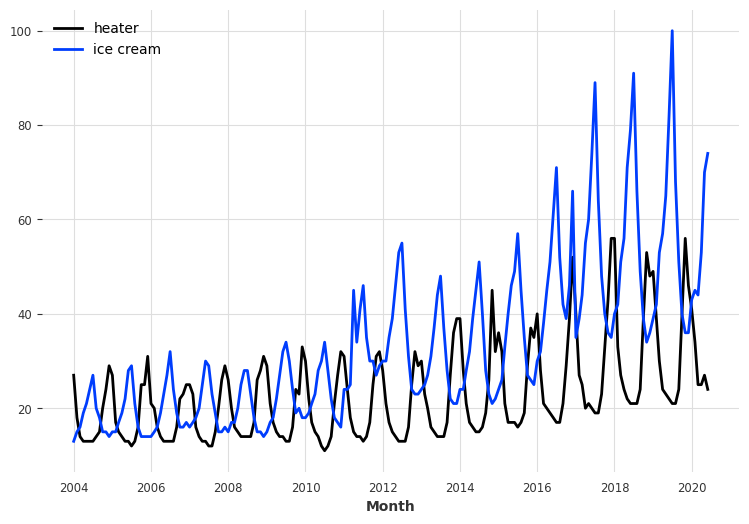

<Figure size 900x600 with 0 Axes>

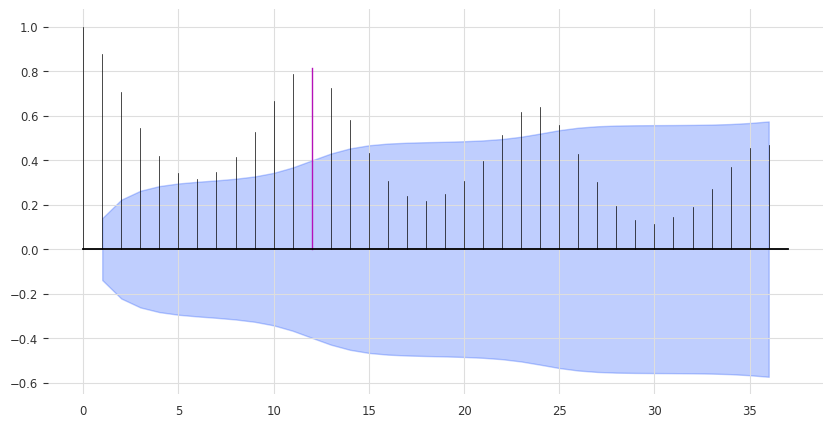

In [74]:
series_ice_heater = IceCreamHeaterDataset().load()

plt.figure(figsize=FIGSIZE)
series_ice_heater.plot()

print(check_seasonality(series_ice_heater["ice cream"], max_lag=36))
print(check_seasonality(series_ice_heater["heater"], max_lag=36))

plt.figure(figsize=FIGSIZE)
plot_acf(series_ice_heater["ice cream"], 12, max_lag=36)  # ~1 year seasonality

## 2.1. Plot Interpretation:
### Plot 1
- **Seasonal Patterns:** Both series show clear seasonal patterns. 
  - The ice cream sales peak during warmer months
  - Heater sales peak during colder months --> shows inverse seasonality.

- **Trend:** Both series show an increasing trend over the years --> growth in sales/ demand for both products.

### Plot 2
- **Autocorrelation:** The ACF plot shows a clear seasonality of 12 months for ice cream series, which shows the correlation of the series with its own past values over different lags.


- **Seasonality Detection:** The plot confirms a strong seasonal component, with significant autocorrelations around lags that correspond to seasonal periods (~12 months).

## 3. Data Transformation

1. **Convert Monthly Sales to Average Daily Sales per Month:**
   - Convert the monthly sales to average daily sales per month to make the series more granular.

2. **Train-Validation Split:**
    - Define the training and validation sets using the transformed series. 
        - The training set includes data until 2 years before the end of the series.
                
3. **Data Transformation:**
   - Transform the data using the `Scaler` transformer.
      - The transformer standardizes the data by subtracting the mean and dividing by the standard deviation.

4. **Define Past Covariates:**
    - Use the heater sales as past covariates (=exogenous variable) for the ice cream sales.
        - The model will use the past heater sales to predict future ice cream sales.
        
    - Transform the covariates using the `Scaler` transformer.

In [58]:
# convert monthly sales to average daily sales per month
converted_series = []
for col in ["ice cream", "heater"]:
    converted_series.append(
        series_ice_heater[col]
        / TimeSeries.from_series(series_ice_heater.time_index.days_in_month)
    )
converted_series = concatenate(converted_series, axis=1)
converted_series = converted_series[pd.Timestamp("20100101") :]

# define train/validation cutoff time
forecast_horizon_ice = 12
training_cutoff_ice = converted_series.time_index[-(2 * forecast_horizon_ice)]

# use ice cream sales as target, create train and validation sets and transform data
series_ice = converted_series["ice cream"]
train_ice, val_ice = series_ice.split_before(training_cutoff_ice)
transformer_ice = Scaler()
train_ice_transformed = transformer_ice.fit_transform(train_ice)
val_ice_transformed = transformer_ice.transform(val_ice)
series_ice_transformed = transformer_ice.transform(series_ice)

# use heater sales as past covariates and transform data
covariates_heat = converted_series["heater"]
cov_heat_train, cov_heat_val = covariates_heat.split_before(training_cutoff_ice)
transformer_heat = Scaler()
transformer_heat.fit(cov_heat_train)
covariates_heat_transformed = transformer_heat.transform(covariates_heat)

In [59]:
# Check the end times of the series
print(f"Train end time: {train_ice.end_time()}")
print(f"Validation end time: {val_ice.end_time()}")

Train end time: 2018-06-01 00:00:00
Validation end time: 2020-06-01 00:00:00


## 4. Model Training 
**Temporal Fusion Transformer (TFT):** 
- **Combines an encoder-decoder** architecture with **multi-head attention mechanisms** and **gating mechanisms** like Gated Residual Networks (GRNs) to **process historical and future covariates simultaneously**. 
- Integrates static covariates, handles complex temporal dependencies, and dynamically weighs the importance of different time steps and features to generate multi-horizon forecasts.

**Define the Model:**
   - Use the `TFTModel` model to train the model.
       - The model uses the last 3 years of data as past input data.
       - The model includes a single LSTM layer with 32 hidden units and a dropout rate of 0.1.
       - The model uses the heater sales as past covariates.
       - The model uses the month as a known future variable (cyclic encoders)
       - The model uses dropout regularization to prevent overfitting.       
       - The model is trained for 300 epochs with a batch size of 16 and a learning rate of 1e-3 (0.0001).
       

In [60]:
# use the last 3 years as past input data
input_chunk_length_ice = 36

# use `add_encoders` as we don't have future covariates
my_model_ice = TFTModel(
    input_chunk_length=input_chunk_length_ice,
    output_chunk_length=forecast_horizon_ice,
    hidden_size=32,
    lstm_layers=1,
    batch_size=16,
    n_epochs=300,
    dropout=0.1,
    add_encoders={"cyclic": {"future": ["month"]}}, #known future variable: month
    add_relative_index=False,
    optimizer_kwargs={"lr": 1e-3},
    random_state=42,
)

# fit the model with past covariates
my_model_ice.fit(
    train_ice_transformed, 
    past_covariates=covariates_heat_transformed, 
    verbose=True
)

Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=32, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=36, output_chunk_length=12, batch_size=16, n_epochs=300, add_encoders={'cyclic': {'future': ['month']}}, optimizer_kwargs={'lr': 0.001}, random_state=42)

## 5. Model Evaluation
**Evaluate the Model:**
   - Evaluate the model using the validation set.
   - Compute the Mean Absolute Percentage Error (MAPE) between the actual and predicted values.
   - Plot the actual and predicted values for the validation set.
 
#### *Note: The cell with eval_model() function was missing from the notebook. I recreated it below.*

In [61]:
def eval_model(model, n, actual_series, val_series):
    pred_series = model.predict(n=n, num_samples=NUM_SAMPLES)

    # plot actual series
    plt.figure(figsize=FIGSIZE)
    actual_series[: pred_series.end_time()].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(
        low_quantile=LOWEST_Q, high_quantile=HIGHEST_Q, label=LABEL_Q_OUTER
    )
    pred_series.plot(low_quantile=LOW_Q, high_quantile=HIGH_Q, label=LABEL_Q_INNER)

    plt.title("MAPE: {:.2f}%".format(mape(val_series, pred_series)))
    plt.legend()


Predicting: |          | 0/? [00:00<?, ?it/s]

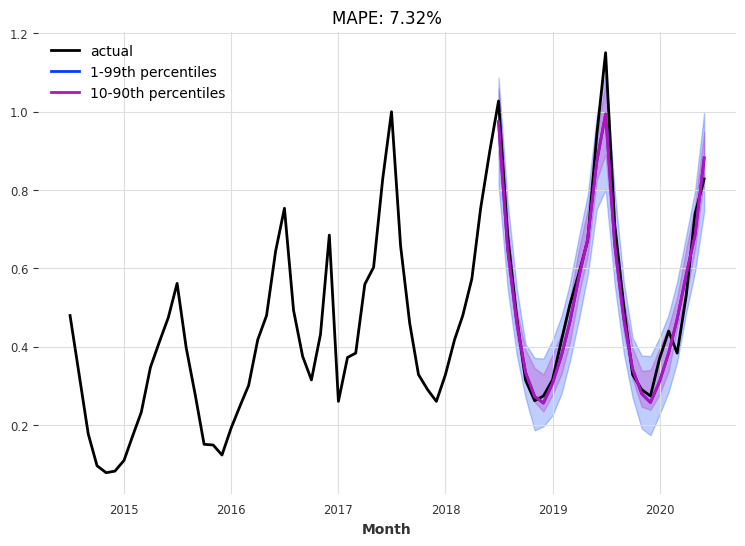

In [62]:
# evaluate the model
n = 24
eval_model(
    model=my_model_ice,
    n=n,
    actual_series=series_ice_transformed[
        train_ice.end_time() - (2 * n - 1) * train_ice.freq :
    ],
    val_series=val_ice_transformed,
)

1.4.1. Model Evaluation: Plot Interpretation
- **Actual vs. Predicted Values:** The plot shows the actual and predicted ice cream sales for the validation set.
- **Quantile Ranges:** The plot includes the 1-99th and 10-90th percentiles of the predicted values.
- **Mean Absolute Percentage Error (MAPE):** The MAPE is computed between the actual and predicted values.
    - The model achieves a MAPE of 7.30% on the validation set, indicating that it it is off by 7.30% on average.
- **Prediction Accuracy:** The model accurately captures the seasonal patterns and trends in the ice cream sales.


## 6. Backtesting
**Backtesting: simulating how the model would have performed in real-time**

   - **Historical Forecasts:** Compute backtest predictions using the historical_forecasts method of the TFT model. 
      - This method allows for rolling forecasts over the validation period. That means the model can be **retrained at each step using the actual data up to that point**.
 
   - Evaluate the backtest predictions and plot the actual and predicted values.


**Why is TFT particularly advantageous for backtesting?**

- **Handling Temporal Dynamics:**
- TFT captures complex temporal patterns by incorporating both past and future covariates -> important for datasets with strong seasonal and trend components.


- **Multi-Horizon Forecasting:**
- TFT can forecast multiple time steps ahead --> suitable for backtesting over different forecast horizons


**Explanation of Parameters:**
- **start:** The start time for the backtesting period, which is the end of the training period.


- **forecast_horizon:** The forecast horizon for the backtesting period, which is 12 months.


- **stride:** The stride parameter in backtesting controls the frequency of the predictions. A stride of 1 means predictions are made at every time step, whereas a larger stride skips some steps, making the backtest less granular but faster.


- **retrain:** The retrain parameter controls whether the model is retrained at each step during backtesting. Setting retrain to False means the model is trained only once at the beginning.


- **overlap_end:** allows the model to use overlapping windows for predictions, which can help in generating more predictions but may introduce some dependency between them.


- **last_points_only:** Whether to use only the last points of the series for backtesting. If set to True, the model is retrained at each step using the actual data up to that point. If set to False, the model is retrained at each step using the entire series up to that point.


In [63]:
# Compute the backtest predictions 
last_points_only = False
backtest_series_ice = my_model_ice.historical_forecasts(
    series_ice_transformed,
    num_samples=NUM_SAMPLES,
    start=training_cutoff_ice,
    forecast_horizon=forecast_horizon_ice,
    stride=1 if last_points_only else forecast_horizon_ice,
    retrain=False,
    last_points_only=last_points_only,
    overlap_end=True,
    verbose=True,
)

backtest_series_ice = (
    concatenate(backtest_series_ice)
    if isinstance(backtest_series_ice, list)
    else backtest_series_ice
)

Predicting: |          | 0/? [00:00<?, ?it/s]

In [64]:
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=FIGSIZE)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=LOWEST_Q, high_quantile=HIGHEST_Q, label=LABEL_Q_OUTER
    )
    backtest_series.plot(low_quantile=LOW_Q, high_quantile=HIGH_Q, label=LABEL_Q_INNER)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                transformer.inverse_transform(actual_series),
                transformer.inverse_transform(backtest_series),
            )
        )
    )

### 6.1. Backtesting without Retraining

MAPE: 4.91%


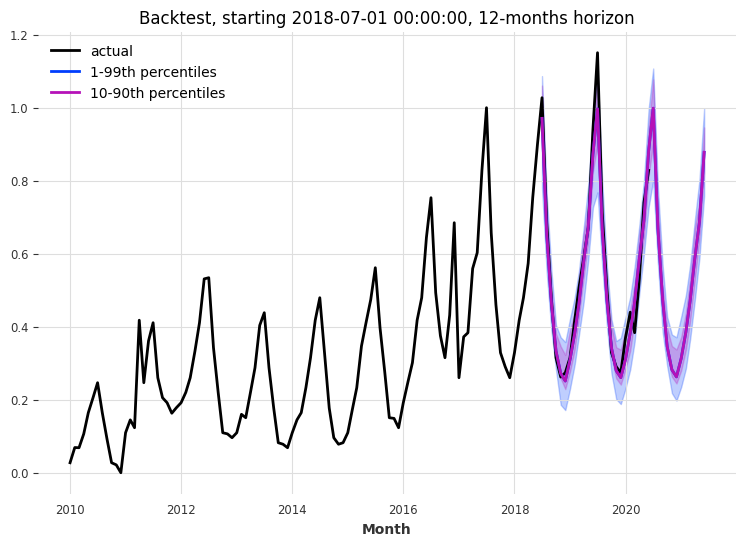

In [65]:
eval_backtest(
    backtest_series=backtest_series_ice,
    actual_series=series_ice_transformed[
        train_ice.start_time() - 2 * forecast_horizon_ice * train_ice.freq :
    ],
    horizon=forecast_horizon_ice,
    start=training_cutoff_ice,
    transformer=transformer_ice,
)

### **MAPE** for the backtesting period is lower than the previous prediction, with a value of 4.86%

**Potential Reasons:**
- Even though the model is not retrained, the historical data used for backtesting is closer in time to the training data than the validation set.



### 6.2. Backtesting with Retraining

In [66]:
# Compute the backtest predictions 
last_points_only = False
backtest_series_ice = my_model_ice.historical_forecasts(
    series_ice_transformed,
    num_samples=NUM_SAMPLES,
    start=training_cutoff_ice,
    forecast_horizon=forecast_horizon_ice,
    stride=1 if last_points_only else forecast_horizon_ice,
    retrain=True,
    last_points_only=last_points_only,
    overlap_end=True,
    verbose=True,
)

backtest_series_ice = (
    concatenate(backtest_series_ice)
    if isinstance(backtest_series_ice, list)
    else backtest_series_ice
)

  0%|          | 0/3 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE: 4.17%


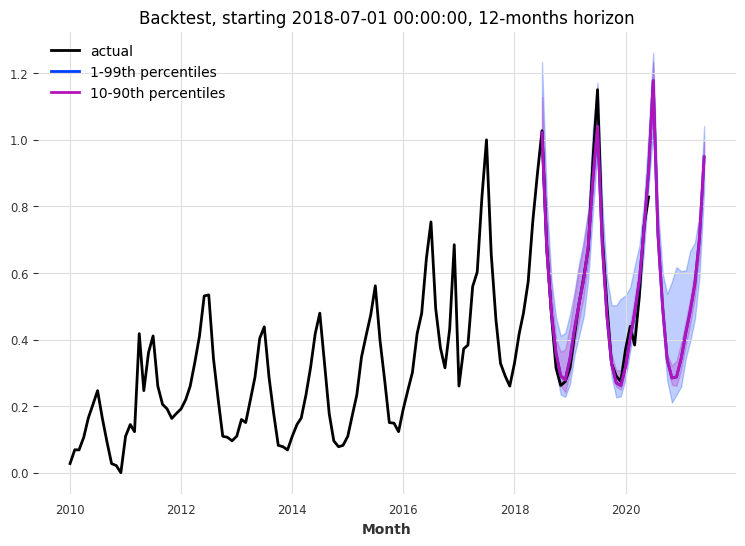

In [67]:
eval_backtest(
    backtest_series=backtest_series_ice,
    actual_series=series_ice_transformed[
        train_ice.start_time() - 2 * forecast_horizon_ice * train_ice.freq :
    ],
    horizon=forecast_horizon_ice,
    start=training_cutoff_ice,
    transformer=transformer_ice,
)

#### **MAPE** for the backtesting period is 4.17% with retraining which is slightly lower than the previous backtest without retraining. 
#### However, the training time was significantly longer due to retraining at each step.

In [68]:
from darts.explainability import TFTExplainer
explainer = TFTExplainer(my_model_ice)
explainability_result = explainer.explain()


Predicting: |          | 0/? [00:00<?, ?it/s]



# **7. Explainability Analysis:**
## **7.1. Variable Importance**

**Encoder Variable Importance**

-Historical Data Processing: The encoder processes past data, identifying which historical variables are most influential in understanding the time series' current state.

**Decoder Variable Importance**

-Forecast Generation: The decoder uses the encoded historical data and future inputs to generate forecasts.


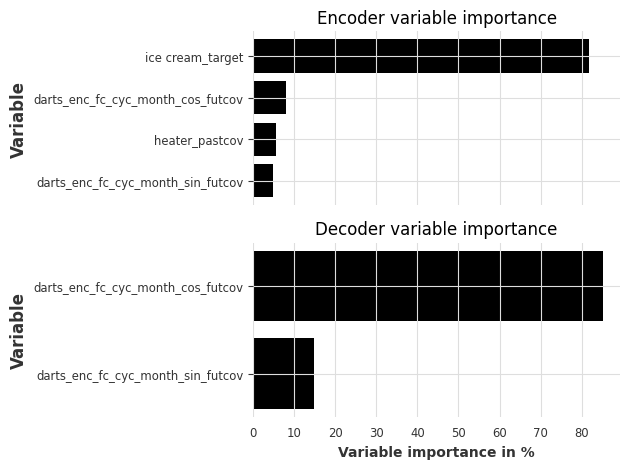

In [69]:
explainer.plot_variable_selection(explainability_result)

### 7.1.1. Interpretation: 

**Encoder Variable Importance:** 

- **ice cream sales** are the most important features for the model
    - Autorregressive component, not surprising

- **darts_enc_fc_cyc_month_cos_futcov**: probably represents a cyclical (seasonal) feature based on the cosine of the month index. 
    - moderate importance --> seasonality plays a significant role in the model's understanding of past data.
  
- **heater_pastcov**: past values of heater sales have some importance. 
    - This implies that heater sales have a predictive relationship with ice cream sales
        - possibly due to inverse seasonal patterns, or because both trends are rising over time (see plot 1 in the notebook)
    
- **darts_enc_fc_cyc_month_sin_futcov**: another cyclical feature based on the sine of the month index. It has low importance in the encoder.




**Decoder Variable Importance:**

- **darts_enc_fc_cyc_month_cos_futcov**: 
    - highest importance in the decoder. 
        - indicates that seasonality is critical for generating future forecasts. 


- **darts_enc_fc_cyc_month_sin_futcov**:
     - reinforces importance of seasonality in the decoder.

## 7.2. Attention Analysis

### 7.2.1. Mean Attention

The mean attention plot shows how the model's attention mechanism assigns importance to different time steps relative to the prediction point.

Index relative to first prediction point: The x-axis represents the time steps relative to the prediction point, with 0 being the point at which predictions start.

Attention: The y-axis represents the attention weights assigned to different time steps.

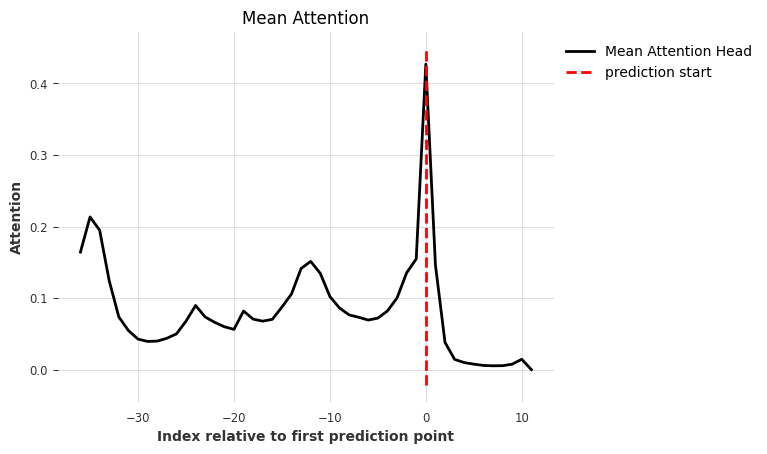

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [70]:
explainer.plot_attention(explainability_result, plot_type="time")

### 7.2.1.1. Interpretation:

**Peak at Prediction Start (Index 0):** 
- There is a significant peak in attention right at the prediction start point (index 0). 
    - Indicates that the most recent time step before making the prediction is extremely important for the model.
        - Makes sense as the most recent data is likely to have the most impact on future predictions (e.g. weather, holidays, etc.)


**Attention Decay:** 
- Attention weights gradually decrease as we move further away from the prediction point into the past. 
    - Suggests that more recent past information is more valuable for the model's predictions.


**Cyclical Patterns:** 
- The attention plot exhibits some cyclical patterns, which could correspond to seasonal trends that the model has learned.

### 7.2.2. Attention per Horizon

Provides insights into how the model's attention mechanism varies across different forecast horizons

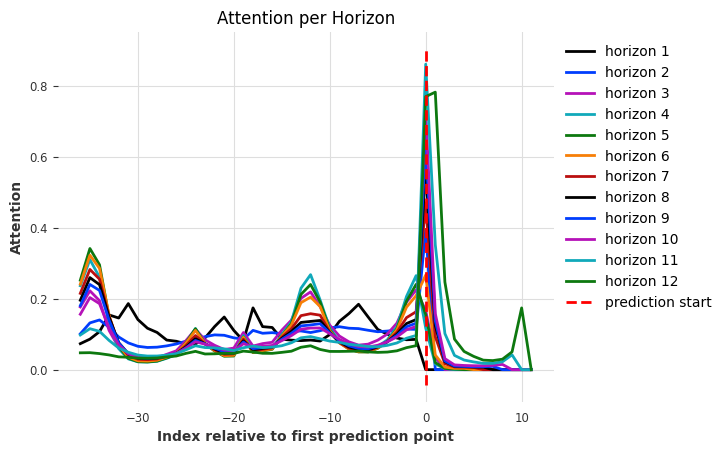

<Axes: title={'center': 'Attention per Horizon'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [71]:
explainer.plot_attention(explainability_result, plot_type="all")

### 7.2.2.1. Interpretation:

**Peak Attention at Prediction Start (Index 0):**

- Significant peak in attention right at the prediction start point (index 0) in all horizons. 


**Attention Decay:**

- Further away from the prediction start point into the past, the attention weights generally decrease. 
    - Consistent across all horizons, suggesting that more recent past information is more valuable for the model's predictions.

**Cyclical Patterns:**

- There are noticeable cyclical patterns in attention weights for different horizons

**Horizon-Specific Variations:**

- While the general trend of peak attention at the prediction start point and decay over time holds for all horizons, there are some variations in the attention weights for different horizons. For example, some horizons show secondary peaks or fluctuations in attention at specific time steps, suggesting that certain historical periods are more influential for specific forecast horizons.
